In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
os.environ['R_HOME']='/home/tguo/tguo2/miniconda3/envs/STAGATE/lib/R'
import sys
from sklearn.metrics.cluster import adjusted_rand_score
import STAGATE
import anndata
import scipy as sp
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import harmonypy as hm

hippo 单独分析DAPI

In [3]:
dirs="/data02/tguo/space_batch_effect/Hippo/"
adata = sc.read_visium(path=dirs+'origin/10X_DAPI', count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2903 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


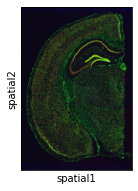

In [5]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires")

------Calculating spatial graph...
The graph contains 16982 edges, 2903 cells.
5.8498 neighbors per cell on average.


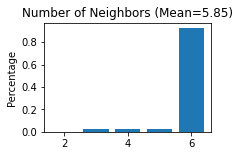

In [6]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=300)
STAGATE.Stats_Spatial_Net(adata)

In [7]:
adata = STAGATE.train_STAGATE(adata, alpha=0.5, pre_resolution=0.2,
                              n_epochs=1000, save_attention=True)

Size of Input:  (2903, 3000)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
------Pre-clustering using louvain with resolution=0.20
------Pruning the graph...
16982 edges before pruning.
15058 edges after pruning.


100%|██████████| 1000/1000 [03:08<00:00,  5.30it/s]


In [9]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=1)

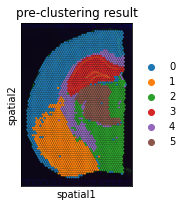

In [8]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color="expression_louvain_label", size=1.5, title='pre-clustering result')

In [10]:
adata.uns['louvain_colors']=['#aec7e8', '#9edae5', '#d62728', '#dbdb8d', '#ff9896',
                             '#8c564b', '#696969', '#778899', '#17becf', '#ffbb78',
                             '#e377c2', '#98df8a', '#aa40fc', '#c5b0d5', '#c49c94',
                             '#f7b6d2', '#279e68', '#b5bd61', '#ad494a', '#8c6d31',
                             '#1f77b4', '#ff7f0e']

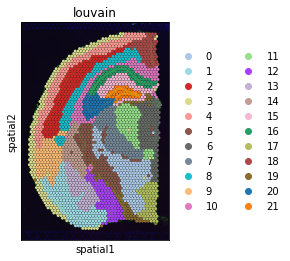

In [11]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.spatial(adata, img_key="hires", color="louvain", size=1.5)

In [12]:
plt.savefig(dirs+"fig/paper/STAGATE_10X_DAPI_domains.png", bbox_inches="tight")

<Figure size 288x288 with 0 Axes>

hippo 整合

In [ ]:
dirs="/data02/tguo/space_batch_effect/Hippo/"
samples=['10X_Normal',"10X_DAPI","10X_FFPE"]
samples1=['Normal',"DAPI","FFPE"]
flags="_"+samples[0]
for i in np.arange(1,len(samples)):
    flags=flags+"_"+samples[i]
rad=[150,300,300]
adata_list = {}
adata = sc.read_visium(path=dirs+'origin/'+samples[0], count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
adata.obs_names=samples1[0]+'-'+adata.obs_names
adata_list[samples[0]] = adata.copy()
STAGATE.Cal_Spatial_Net(adata_list[samples[0]], rad_cutoff=rad[0])
for i in np.arange(1,len(samples)):
    adata = sc.read_visium(path=dirs+'origin/'+samples[i], count_file='filtered_feature_bc_matrix.h5')
    adata.var_names_make_unique()
    adata.obs_names=samples1[i]+'-'+adata.obs_names
    adata_list[samples[i]] = adata.copy()
    STAGATE.Cal_Spatial_Net(adata_list[samples[i]], rad_cutoff=rad[i])

adata = sc.concat([adata_list[x] for x in samples], keys=None)
adata.uns['Spatial_Net'] = pd.concat([adata_list[x].uns['Spatial_Net']  for x in samples])
STAGATE.Stats_Spatial_Net(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata = STAGATE.train_STAGATE(adata, alpha=0.5, pre_resolution=0.2,n_epochs=1000, save_attention=True)

sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
adata.obs['Tech'] = [x.split('-')[0] for x in adata.obs_names]
adata.obs['Tech'] 
data=adata.obsm['STAGATE']
data=pd.DataFrame(data,index=adata.obs_names,columns=['STAGATE_'+str(i) for i in np.arange(data.shape[1])])
data.to_csv(dirs+"methods/STAGATE_mat"+flags+"_modify.csv")

data_mat = adata.obsm['STAGATE'].copy()
meta_data = adata.obs.copy()
ho = hm.run_harmony(data_mat, meta_data, ['Tech'])
res = pd.DataFrame(ho.Z_corr).T
res.index = adata.obs_names
res.columns=['harmony-STAGATE_'+str(i) for i in np.arange(res.shape[1])]
res.to_csv(dirs+"methods/harmony_STAGATE_mat"+flags+"_modify_python.txt")
# res.to_csv(dirs+"methods/harmony_STAGATE_mat"+flags+".txt")
adata_Harmony = sc.AnnData(res.T)
adata_Harmony.obsm['spatial'] = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names).loc[adata_Harmony.obs_names,].values
adata_Harmony.obs['Tech'] = adata.obs.loc[adata_Harmony.obs_names, 'Tech']
sc.pp.neighbors(adata_Harmony)
sc.tl.umap(adata_Harmony)
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_Harmony, color='Tech', title='STAGATE + Harmony')


adata_Harmony = sc.AnnData(res)
adata_Harmony.obsm['spatial'] = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names).loc[adata_Harmony.obs_names,].values
adata_Harmony.obs['Tech'] = adata.obs.loc[adata_Harmony.obs_names, 'Tech']
sc.pp.neighbors(adata_Harmony)
sc.tl.umap(adata_Harmony)
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_Harmony, color='Tech', title='STAGATE + Harmony')
sc.pp.neighbors(adata_Harmony)
sc.tl.umap(adata_Harmony)
sc.tl.louvain(adata_Harmony, resolution=1.5)

sc.tl.louvain(adata_Harmony, resolution=1.0)
ub=np.unique(adata_Harmony.obs['Tech'])
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
it=0
for temp_tech in ub:
    temp_adata = adata_Harmony[adata_Harmony.obs['Tech']==temp_tech, ]
    if it == 2:
        sc.pl.embedding(temp_adata, basis="spatial", color="louvain",s=50, ax=axs[it],
                        show=False, title=temp_tech)
    else:
        sc.pl.embedding(temp_adata, basis="spatial", color="louvain",s=50, ax=axs[it], legend_loc=None,
                        show=False, title=temp_tech)
    it+=1


DLPFC

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


------Calculating spatial graph...
The graph contains 24762 edges, 4221 cells.
5.8664 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 25692 edges, 4381 cells.
5.8644 neighbors per cell on average.
Size of Input:  (8602, 3000)


100%|██████████| 500/500 [04:22<00:00,  1.91it/s]


fitting ...
  |======================================================================| 100%
0.5036280077045717
ARI of section ID 151507: 0.501
ARI of section ID 151508: 0.513


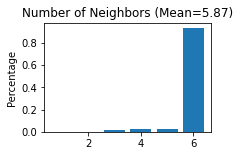

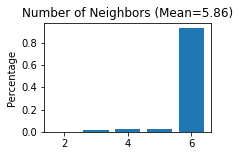

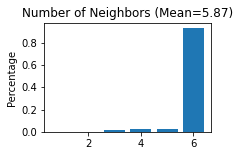

In [12]:
dirs="/data02/tguo/space_batch_effect/human_DLPFC_10x/"
sample_names=np.array([151507,151508,151509,151510,151669,151670,151671,151672,151673,151674,151675,151676])
IDX=[[0,1],[1,2],[2,3],[4,5],[5,6],[6,7],[8,9],[9,10],[10,11]]
for idx in np.arange(1):
    sample_name=sample_names[IDX[idx]]
    flags=""
    for i in range(len(sample_name)):
        flags=flags+"_"+str(sample_name[i])


    adata_list = {}
    for section_id in sample_name:
        adata = sc.read_visium(path=dirs+"scanpy_file/"+str(section_id)+"/",
                               count_file="filtered_feature_bc_matrix.h5")
        adata.var_names_make_unique()
        adata.obs_names=[str(section_id)+'-'+x for x in adata.obs_names]
        Ann_df=pd.read_csv(dirs+"input/"+str(section_id)+"_label.txt", sep=',', header=0, index_col=0)
        Ann_df.columns=['Ground Truth','Sample']
        adata=adata[Ann_df.index,:]
        adata.obs['Ground Truth']=Ann_df.loc[:,'Ground Truth']
        adata.obs['sample']=Ann_df.loc[:,'Sample']
        adata_list[str(section_id)] = adata.copy()

    for section_id in sample_name:
        STAGATE.Cal_Spatial_Net(adata_list[str(section_id)], rad_cutoff=150)
        STAGATE.Stats_Spatial_Net(adata_list[str(section_id)])

    adata = sc.concat([adata_list[str(x)] for x in sample_name], keys=None)
    adata.uns['Spatial_Net'] = pd.concat([adata_list[str(x)].uns['Spatial_Net'] for x in sample_name])
    STAGATE.Stats_Spatial_Net(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = STAGATE.train_STAGATE(adata, alpha=0)
    cell_names=np.array(adata.obs_names)
    a=pd.DataFrame(adata.obsm['STAGATE'],index=cell_names,columns=['STAGATE_'+str(i) for i in range(adata.obsm['STAGATE'].shape[1])])
    a.to_csv(dirs+"methods/harmony_STAGATE_mat"+flags+".txt")

    sc.pp.neighbors(adata, use_rep='STAGATE')
    sc.tl.umap(adata)
    adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=7)
    from sklearn.metrics.cluster import adjusted_rand_score
    adata_obs = adata.obs.dropna()
    print(adjusted_rand_score(adata_obs['mclust'], adata_obs['Ground Truth']))
    for section_id in sample_name:
        temp_adata = adata[adata.obs['sample']==section_id]
        temp_obs = temp_adata.obs.dropna()
        temp_ARI = adjusted_rand_score(temp_obs['mclust'], temp_obs['Ground Truth'])
        print('ARI of section ID %s: %.3f' %(str(section_id), temp_ARI))


####harmony#####
# data_mat = adata.obsm['STAGATE'].copy()
# meta_data = adata.obs.copy()
# meta_data.loc[:,'sample']=[str(x) for x in meta_data.loc[:,'sample']]
# ho = hm.run_harmony(data_mat, meta_data, ['sample'])
# res = pd.DataFrame(ho.Z_corr).T
# res.index = adata.obs_names
# res.columns=['harmony-STAGATE_'+str(i) for i in np.arange(res.shape[1])]
# res.to_csv(dirs+"methods/harmony_STAGATE_mat"+flags+"_1.txt")
# adata_Harmony = sc.AnnData(res)
# adata_Harmony.obsm['spatial'] = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names).loc[adata_Harmony.obs_names,].values
# adata_Harmony.obs['sample'] = adata.obs.loc[adata_Harmony.obs_names, 'sample']
# sc.pp.neighbors(adata_Harmony)
# sc.tl.umap(adata_Harmony)
# plt.rcParams["figure.figsize"] = (3, 3)
# sc.pl.umap(adata_Harmony, color='sample', title='STAGATE + Harmony')



In [92]:
# adata_Harmony.obsm['STAGATE']=adata_Harmony.X
# sc.pp.neighbors(adata_Harmony, use_rep='STAGATE')
# sc.tl.umap(adata_Harmony)
# adata_Harmony = STAGATE.mclust_R(adata_Harmony, used_obsm='STAGATE', num_cluster=7)
adata_Harmony.obs['Ground Truth']=adata.obs.loc[adata_Harmony.obs_names,'Ground Truth']
from sklearn.metrics.cluster import adjusted_rand_score
adata_Harmony_obs = adata_Harmony.obs.dropna()
print(adjusted_rand_score(adata_Harmony_obs['mclust'], adata_Harmony_obs['Ground Truth']))
for section_id in sample_name:
    temp_adata = adata_Harmony[adata_Harmony.obs['sample']==section_id]
    temp_obs = temp_adata.obs.dropna()
    temp_ARI = adjusted_rand_score(temp_obs['mclust'], temp_obs['Ground Truth'])
    print('ARI of section ID %s: %.3f' %(str(section_id), temp_ARI))


0.48394817675785107
ARI of section ID 151507: 0.526
ARI of section ID 151508: 0.522
ARI of section ID 151509: 0.558
ARI of section ID 151510: 0.577
ARI of section ID 151669: 0.379
ARI of section ID 151670: 0.350
ARI of section ID 151671: 0.583
ARI of section ID 151672: 0.593
ARI of section ID 151673: 0.593
ARI of section ID 151674: 0.574
ARI of section ID 151675: 0.536
ARI of section ID 151676: 0.572


mouse brain

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


------Calculating spatial graph...
The graph contains 15686 edges, 2696 cells.
5.8182 neighbors per cell on average.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


------Calculating spatial graph...
The graph contains 16456 edges, 2825 cells.
5.8251 neighbors per cell on average.
Size of Input:  (5521, 3000)
------Pre-clustering using louvain with resolution=0.20
------Pruning the graph...
32142 edges before pruning.
28126 edges after pruning.


100%|██████████| 1000/1000 [05:41<00:00,  2.93it/s]


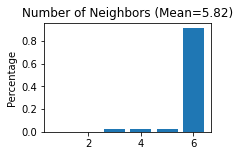

In [114]:
dirs="/data02/tguo/space_batch_effect/mouse_brain/"
# samples=["all_posterior1","all_posterior2","all_anterior1","all_anterior2"]
# samples1=["posterior1","posterior2","anterior1","anterior2"]

# samples=["all_posterior1","all_posterior2"]
# samples1=["posterior1","posterior2"]


samples=["all_anterior1","all_anterior2"]
samples1=["anterior1","anterior2"]

flags="_"+samples[0]
for i in np.arange(1,len(samples)):
    flags=flags+"_"+samples[i]
rad=[150,150,150,150]
adata_list = {}
adata = sc.read_visium(path=dirs+'origin/origin/'+samples[0], count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
adata.obs_names=samples1[0]+'-'+adata.obs_names
adata_list[samples[0]] = adata.copy()
STAGATE.Cal_Spatial_Net(adata_list[samples[0]], rad_cutoff=rad[0])
for i in np.arange(1,len(samples)):
    adata = sc.read_visium(path=dirs+'origin/origin/'+samples[i], count_file='filtered_feature_bc_matrix.h5')
    adata.var_names_make_unique()
    adata.obs_names=samples1[i]+'-'+adata.obs_names
    adata_list[samples[i]] = adata.copy()
    STAGATE.Cal_Spatial_Net(adata_list[samples[i]], rad_cutoff=rad[i])


adata = sc.concat([adata_list[x] for x in samples], keys=None)
adata.uns['Spatial_Net'] = pd.concat([adata_list[x].uns['Spatial_Net']  for x in samples])
STAGATE.Stats_Spatial_Net(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata = STAGATE.train_STAGATE(adata, alpha=0.5, pre_resolution=0.2,n_epochs=1000, save_attention=True)
adata.obs['Tech']=[x.split('-')[0] for x in adata.obs_names]

cell_names=np.array(adata.obs_names)
cell_names=[x.split('-')[0]+'-'+x.split('-')[1]+'.'+'1' for x in cell_names]
a=pd.DataFrame(adata.obsm['STAGATE'],index=cell_names,columns=['STAGATE_'+str(i) for i in range(adata.obsm['STAGATE'].shape[1])])
a.to_csv(dirs+"methods/harmony_STAGATE_mat"+flags+".txt")

2023-05-18 15:45:18,254 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-05-18 15:45:37,302 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-05-18 15:45:37,452 - harmonypy - INFO - Iteration 1 of 10
2023-05-18 15:45:42,098 - harmonypy - INFO - Iteration 2 of 10
2023-05-18 15:45:45,012 - harmonypy - INFO - Iteration 3 of 10
2023-05-18 15:45:46,470 - harmonypy - INFO - Iteration 4 of 10
2023-05-18 15:45:47,917 - harmonypy - INFO - Converged after 4 iterations
... storing 'Tech' as categorical


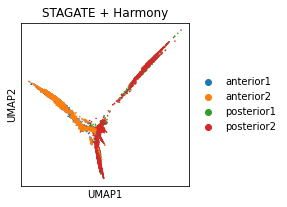

In [107]:
#######harmony#######
data_mat = adata.obsm['STAGATE'].copy()
meta_data = adata.obs.copy()
ho = hm.run_harmony(data_mat, meta_data, ['Tech'])
res = pd.DataFrame(ho.Z_corr).T
res.index = adata.obs_names
res.index=[x.split('-')[0]+'-'+x.split('-')[1]+'.'+'1' for x in res.index]
res.columns=['harmony-STAGATE_'+str(i) for i in np.arange(res.shape[1])]
res.to_csv(dirs+"methods/harmony_STAGATE_mat"+flags+".txt")
adata_Harmony = sc.AnnData(res)
adata_Harmony.obsm['spatial'] = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names).loc[adata_Harmony.obs_names,].values
adata_Harmony.obs['Tech'] = adata.obs.loc[adata_Harmony.obs_names, 'Tech']
sc.pp.neighbors(adata_Harmony)
sc.tl.umap(adata_Harmony)
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_Harmony, color='Tech', title='STAGATE + Harmony')

mouse OB：BIN50

对于bin50的stereo-seq数据的domain划分结果

------Calculating spatial graph...
The graph contains 69426 edges, 8827 cells.
7.8652 neighbors per cell on average.
Size of Input:  (8827, 3000)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|██████████| 500/500 [05:39<00:00,  1.47it/s]


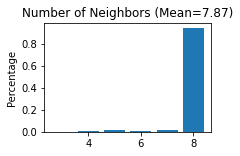

In [2]:
dirs="/data02/tguo/space_batch_effect/mouse_OB/"
samples=['BGI','SlideV2','10X']
adata = pd.read_csv(dirs+"gtt_input/BGI_SlideV2_10X/"+str(samples[0])+"_allgene_mat.csv",header=0,index_col=0,sep=',')
adata = anndata.AnnData(adata)
adata.var_names_make_unique()
coord=pd.read_csv(dirs+"gtt_input/BGI_SlideV2_10X/"+str(samples[0])+"_coord.csv",header=0,index_col=0,sep=',')
adata.obsm['spatial']=coord.loc[adata.obs_names,:]
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

STAGATE.Cal_Spatial_Net(adata, rad_cutoff=1.5)
STAGATE.Stats_Spatial_Net(adata)

adata = STAGATE.train_STAGATE(adata, alpha=0)
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

(-5.0, 127.0, -3.6500000000000004, 98.65)

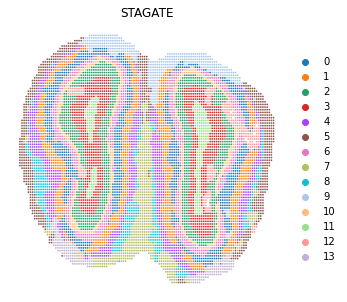

In [10]:
res=1.5
sc.tl.louvain(adata, resolution=res)
adata.obs.to_csv(dirs+"methods/STAGATE_BGI_Bin50_louvain_clusters_"+str(res)+".csv")
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=12, show=False, title='STAGATE')
plt.axis('off')

In [70]:
a=np.array([str(x) for x in np.arange(10)])
b=np.array(['ONL','GL_2','GL_1','GCL_1','GCL_2','EPL','ONL','ONL','MCL','UN'])
clust=adata.obs['louvain']
clust1=pd.DataFrame(b.tolist()*2000)
for i in np.arange(clust.shape[0]):
    clust1.iloc[i,0]=b[np.where(a==clust.iloc[i])[0]][0]
clust1=clust1.iloc[0:clust.shape[0],:]
clust1.index=clust.index
clust1.columns=['celltype']
clust1.to_csv(dirs+"methods/STAGATE_BGI_annotations.csv")

bin35的划分

(27106, 19527) (19527, 2)


Trying to set attribute `.var` of view, copying.


After flitering:  (19109, 14376)


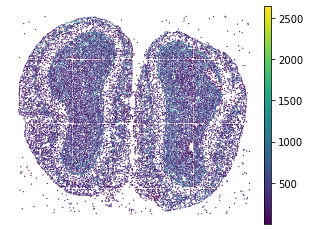

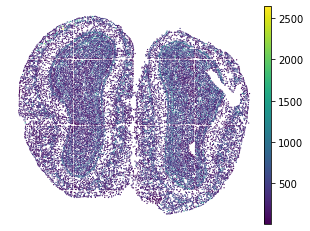

In [24]:
counts_file = os.path.join(dirs+"origin/Dataset1_LiuLongQi_MouseOlfactoryBulb/RNA_counts.tsv")
coor_file = os.path.join(dirs+"origin/Dataset1_LiuLongQi_MouseOlfactoryBulb/position.tsv")
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, sep='\t')
print(counts.shape, coor_df.shape)


counts.columns = ['Spot_'+str(x) for x in counts.columns]
coor_df.index = coor_df['label'].map(lambda x: 'Spot_'+str(x))
coor_df = coor_df.loc[:, ['x','y']]
coor_df.to_csv(dirs+"gtt_input/BGI_bin35_coord.csv")
coor_df.head()

adata = sc.AnnData(counts.T)
adata.var_names_make_unique()
adata

coor_df = coor_df.loc[adata.obs_names, ['y', 'x']]
adata.obsm["spatial"] = coor_df.to_numpy()
sc.pp.calculate_qc_metrics(adata, inplace=True)

plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

used_barcode = pd.read_csv(os.path.join(dirs,'origin/Dataset1_LiuLongQi_MouseOlfactoryBulb/stereo-seq_used_barcodes.txt'), sep='\t', header=None)
used_barcode = used_barcode[0]
adata = adata[used_barcode,]
adata

plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

sc.pp.filter_genes(adata, min_cells=50)
print('After flitering: ', adata.shape)

------Calculating spatial graph...
The graph contains 144318 edges, 19109 cells.
7.5524 neighbors per cell on average.
Size of Input:  (19109, 3000)


100%|██████████| 500/500 [11:59<00:00,  1.44s/it]


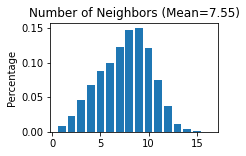

In [26]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=50)
STAGATE.Stats_Spatial_Net(adata)
adata = STAGATE.train_STAGATE(adata, alpha=0)

sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)



(6005.190789473685, 12428.6600877193, 9986.774763741741, 15062.302776957436)

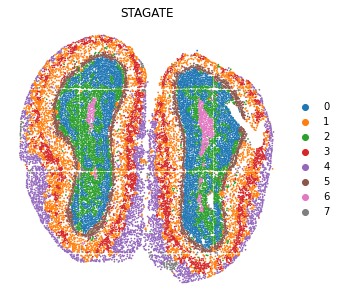

In [32]:
# sc.tl.louvain(adata, resolution=0.9)
# adata.obs.to_csv(dirs+"methods/STAGATE_BGI_Bin34_louvain_clusters_"+str(res)+".csv")
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=12, show=False, title='STAGATE')
plt.axis('off')
sc.pl.umap(adata, color='louvain', title='STAGATE')

In [45]:
a=np.array([str(x) for x in np.arange(8)])
b=np.array(['GCL_2','EPL','GCL_1','GL','ONL','MCL','RMS','UNK'])
clust=adata.obs['louvain']
clust1=pd.DataFrame(b.tolist()*20000)
for i in np.arange(clust.shape[0]):
    clust1.iloc[i,0]=b[np.where(a==clust.iloc[i])[0]][0]
clust1=clust1.iloc[0:clust.shape[0],:]
clust1.index=clust.index
clust1.columns=['celltype']
clust1.to_csv(dirs+"methods/STAGATE_BGI_bin35_annotations.csv")

------Calculating spatial graph...
The graph contains 144318 edges, 19109 cells.
7.5524 neighbors per cell on average.
Size of Input:  (19109, 3000)


100%|██████████| 500/500 [11:59<00:00,  1.44s/it]


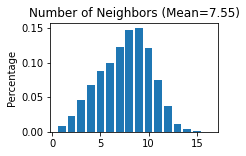

In [20]:
# adata=sc.read(dirs+"origin/Stereo-seq_MoB.h5ad")
# adata.var_names_make_unique()
# sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# STAGATE.Cal_Spatial_Net(adata, rad_cutoff=50)
# STAGATE.Stats_Spatial_Net(adata)

# adata = STAGATE.train_STAGATE(adata, alpha=0)
# sc.pp.neighbors(adata, use_rep='STAGATE')
# sc.tl.umap(adata)
# res=0.8
# sc.tl.louvain(adata, resolution=res)
# adata.obs.to_csv(dirs+"methods/STAGATE_BGI_Bin34_louvain_clusters_"+str(res)+".csv")
# plt.rcParams["figure.figsize"] = (5, 5)
# sc.pl.embedding(adata, basis="spatial", color="louvain",s=12, show=False, title='STAGATE')
# plt.axis('off')

对于slidev2数据的domain划分结果

Trying to set attribute `._uns` of view, copying.


------Calculating spatial graph...
The graph contains 228300 edges, 20139 cells.
11.3362 neighbors per cell on average.
Size of Input:  (20139, 3000)


100%|██████████| 500/500 [16:27<00:00,  1.97s/it]


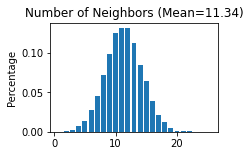

In [91]:
dirs="/data02/tguo/space_batch_effect/mouse_OB/"
adata = sc.read(dirs+"origin/Slide-seqV2_MoB.h5ad")
# adata = pd.read_csv(dirs+"gtt_input/"+str(samples[1])+"_allgene_mat.csv",header=0,index_col=0,sep=',')
adata = anndata.AnnData(adata)
adata.var_names_make_unique()
used_barcode=pd.read_csv(dirs+'origin/used_barcodes.txt',header=None).values[:,0]
cells=np.intersect1d(used_barcode,adata.obs_names)
adata=adata[cells,]

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

STAGATE.Cal_Spatial_Net(adata, rad_cutoff=50)
STAGATE.Stats_Spatial_Net(adata)

adata = STAGATE.train_STAGATE(adata, alpha=0)
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=0.5)
adata.obs.to_csv(dirs+"methods/STAGATE_SlideV2-v2_louvain_clusters.csv")

(588.545, 5108.555, 847.6700000000001, 5670.73)

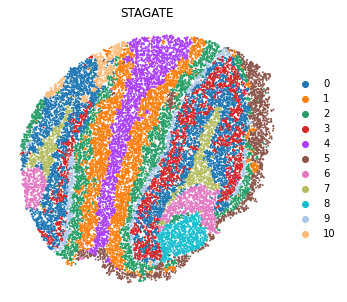

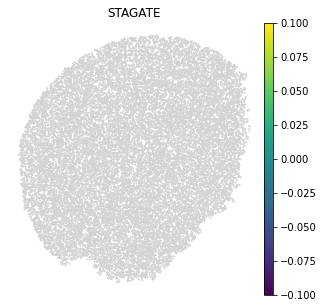

In [96]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=15, show=False, title='STAGATE')
plt.axis('off')
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(adata, basis="spatial", color="celltype",s=15, show=False, title='STAGATE')
plt.axis('off')

In [94]:
a=np.array([str(x) for x in np.arange(11)])
b=np.array(['GCL_2','GL_2','EPL','GCL_1','ONL','GL_1','AOB','RMS','AOBgr','MCL','UN'])
clust=adata.obs
clust1=pd.DataFrame(b.tolist()*2000)
for i in np.arange(clust.shape[0]):
    clust1.iloc[i,0]=b[np.where(a==clust.iloc[i,0])[0]][0]
clust1=clust1.iloc[0:clust.shape[0],:]
clust1.index=clust.index
clust1.columns=clust.columns
clust1.index=['SlideV2-'+x for x in clust1.index]
clust1.to_csv(dirs+"methods/STAGATE_SlideV2-v2_annotations.csv")

In [95]:
adata.obs['celltype']=clust1

对于10X数据的domain划分结果

Size of Input:  (1185, 3000)


100%|██████████| 500/500 [00:41<00:00, 12.15it/s]


(2533.3, 7828.7, 3791.35, 7369.65)

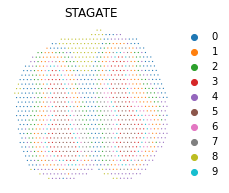

In [78]:
# dirs="/data02/tguo/space_batch_effect/mouse_OB/"

# adata = pd.read_csv(dirs+"gtt_input/BGI_SlideV2_10X/10X_allgene_mat.csv",header=0,index_col=0,sep=',')
# adata = anndata.AnnData(adata)
# adata.var_names_make_unique()
# coord=pd.read_csv(dirs+"gtt_input/BGI_SlideV2_10X/10X_coord.csv",header=0,index_col=0,sep=',')
# adata.obsm['spatial']=coord.loc[adata.obs_names,:]
# sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150)
# STAGATE.Stats_Spatial_Net(adata)

adata = STAGATE.train_STAGATE(adata, alpha=0)
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=0.8)
adata.obs.to_csv(dirs+"methods/STAGATE_10X_louvain_clusters.csv")
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=6, show=False, title='STAGATE')
plt.axis('off')

(2533.3, 7828.7, 3791.35, 7369.65)

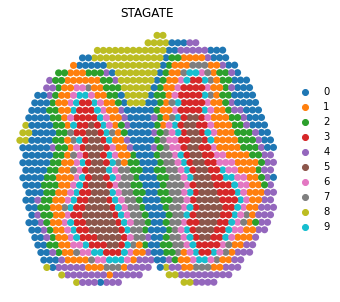

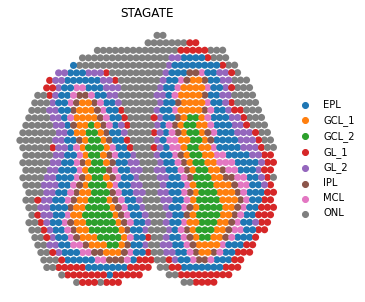

In [90]:
# sc.tl.louvain(adata, resolution=1.0)
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=200, show=False, title='STAGATE')
plt.axis('off')

plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(adata, basis="spatial", color="celltype",s=200, show=False, title='STAGATE')
plt.axis('off')

In [86]:
a=np.array([str(x) for x in np.arange(10)])
b=np.array(['ONL','EPL','GL_2','GCL_1','GL_1','RMS','MCL','EPL','ONL','IPL'])
clust=adata.obs
clust1=pd.DataFrame(b.tolist()*2000)
for i in np.arange(clust.shape[0]):
    clust1.iloc[i,0]=b[np.where(a==clust.iloc[i,0])[0]][0]
clust1=clust1.iloc[0:clust.shape[0],:]
clust1.index=clust.index
clust1.columns=clust.columns
adata.obs['celltype']=clust1

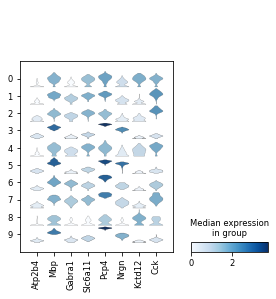

In [89]:
marker_genes=['Atp2b4','Mbp','Gabra1','Slc6a11','Pcp4','Nrgn','Kctd12','Cck']
sc.pl.stacked_violin(adata, marker_genes, groupby='louvain')

整合 bin50

------Calculating spatial graph...
The graph contains 69426 edges, 8827 cells.
7.8652 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 228276 edges, 20138 cells.
11.3356 neighbors per cell on average.


Size of Input:  (28965, 3000)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|██████████| 500/500 [20:38<00:00,  2.48s/it]
... storing 'Tech' as categorical


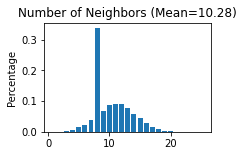

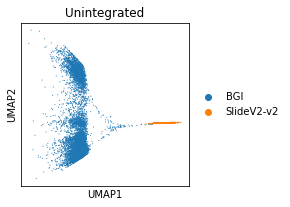

In [20]:
dirs="/data02/tguo/space_batch_effect/mouse_OB/"
samples=['BGI','SlideV2-v2']

flags="_"+samples[0]
for i in np.arange(1,len(samples)):
    flags=flags+"_"+samples[i]

adata_list={}
adata = pd.read_csv(dirs+"gtt_input/"+str(samples[0])+"_allgene_mat.csv",header=0,index_col=0,sep=',')
adata = anndata.AnnData(adata)
adata.var_names_make_unique()
coord=pd.read_csv(dirs+"gtt_input/"+str(samples[0])+"_coord.csv",header=0,index_col=0,sep=',')
adata.obsm['spatial']=coord.loc[adata.obs_names,:]
adata_list[samples[0]] = adata.copy()

adata = sc.read(dirs+"origin/Slide-seqV2_MoB.h5ad")
adata = anndata.AnnData(adata)
adata.var_names_make_unique()
used_barcode=pd.read_csv(dirs+'origin/used_barcodes.txt',header=None).values[:,0]
cells=np.intersect1d(used_barcode,adata.obs_names)
adata=adata[cells,]
adata.obs_names=['SlideV2-'+x for x in adata.obs_names]
coord=pd.read_csv(dirs+"gtt_input/"+str(samples[1])+"_coord.csv",header=0,index_col=0,sep=',')
cells=np.intersect1d(adata.obs_names,coord.index)
adata=adata[cells,]
adata.obsm['spatial']=coord.loc[cells,:]
adata_list[samples[1]] = adata.copy()

STAGATE.Cal_Spatial_Net(adata_list[samples[0]], rad_cutoff=1.5)
STAGATE.Cal_Spatial_Net(adata_list[samples[1]], rad_cutoff=50)
adata = sc.concat([adata_list[x] for x in samples], keys=None)
adata.uns['Spatial_Net'] = pd.concat([adata_list[x].uns['Spatial_Net']  for x in samples])
STAGATE.Stats_Spatial_Net(adata)

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.obs['Tech'] = [samples[0]]*adata_list[samples[0]].shape[0]+[samples[1]]*adata_list[samples[1]].shape[0]
adata = STAGATE.train_STAGATE(adata, alpha=0)
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='Tech', title='Unintegrated')

# cell_names=np.array(adata.obs_names)
# cell_names=[x.split('-')[0]+'-'+x.split('-')[1]+'.'+'1' for x in cell_names]
# a=pd.DataFrame(adata.obsm['STAGATE'],index=cell_names,columns=['STAGATE_'+str(i) for i in range(adata.obsm['STAGATE'].shape[1])])
# a.to_csv(dirs+"methods/harmony_STAGATE_mat"+flags+".txt")

In [82]:
import harmonypy as hm
data_mat = adata.obsm['STAGATE'].copy()
meta_data = adata.obs.copy()
ho = hm.run_harmony(data_mat, meta_data, ['Tech'])
res = pd.DataFrame(ho.Z_corr).T
res.index = adata.obs_names
res.columns=['harmony-STAGATE_'+str(i) for i in np.arange(res.shape[1])]
res.to_csv(dirs+"methods/harmony_STAGATE_mat"+flags+".txt")

In [83]:
adata_Harmony = sc.AnnData(res)
adata_Harmony.obsm['spatial'] = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names).loc[adata_Harmony.obs_names,].values
adata_Harmony.obs['Tech'] = adata.obs.loc[adata_Harmony.obs_names, 'Tech']
sc.pp.neighbors(adata_Harmony)
sc.tl.umap(adata_Harmony)


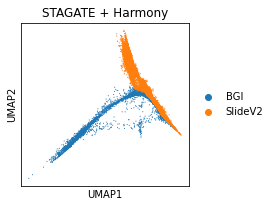

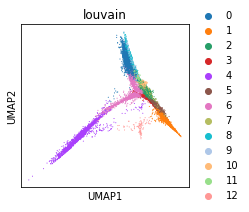

In [94]:
sc.tl.louvain(adata_Harmony, resolution=0.5)
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_Harmony, color='Tech', title='STAGATE + Harmony')
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_Harmony, color='louvain')

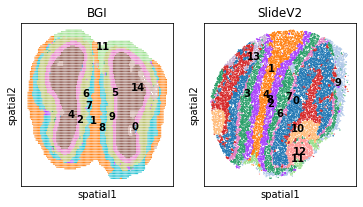

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
it=0
for temp_tech in samples:
    temp_adata = adata_Harmony[adata_Harmony.obs['Tech']==temp_tech, ]
    if it == 1:
        sc.pl.embedding(temp_adata, basis="spatial", color="louvain",s=6, ax=axs[it],
                        show=False, title=temp_tech,legend_loc='on data')
    else:
        sc.pl.embedding(temp_adata, basis="spatial", color="louvain",s=6, ax=axs[it], legend_loc='on data',
                        show=False, title=temp_tech)
    it+=1

整合 bin35

------Calculating spatial graph...
The graph contains 144318 edges, 19109 cells.
7.5524 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 228300 edges, 20139 cells.
11.3362 neighbors per cell on average.
Size of Input:  (39248, 3000)


100%|██████████| 500/500 [26:40<00:00,  3.20s/it]
... storing 'Tech' as categorical


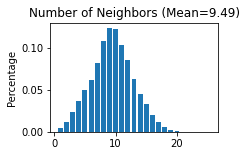

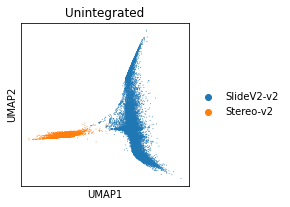

In [19]:
dirs="/data02/tguo/space_batch_effect/mouse_OB/"
samples=['Stereo-v2','SlideV2-v2']
flags="_"+samples[0]
for i in np.arange(1,len(samples)):
    flags=flags+"_"+samples[i]

adata_list={}
adata = sc.read(dirs+"origin/Stereo-seq_MoB.h5ad",header=0,index_col=0,sep=',')
adata = anndata.AnnData(adata)
adata.var_names_make_unique()
adata.obs_names = ['Stereo-'+x for x in adata.obs_names]
adata_list[samples[0]] = adata.copy()

adata = sc.read(dirs+"origin/Slide-seqV2_MoB.h5ad")
adata = anndata.AnnData(adata)
adata.var_names_make_unique()
adata.obs_names = ['SlideV2-'+x for x in adata.obs_names]
adata_list[samples[1]] = adata.copy()

STAGATE.Cal_Spatial_Net(adata_list[samples[0]], rad_cutoff=50)
STAGATE.Cal_Spatial_Net(adata_list[samples[1]], rad_cutoff=50)
adata = sc.concat([adata_list[x] for x in samples], keys=None)
adata.uns['Spatial_Net'] = pd.concat([adata_list[x].uns['Spatial_Net']  for x in samples])
STAGATE.Stats_Spatial_Net(adata)

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.obs['Tech'] = [samples[0]]*adata_list[samples[0]].shape[0]+[samples[1]]*adata_list[samples[1]].shape[0]
adata = STAGATE.train_STAGATE(adata, alpha=0)
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='Tech', title='Unintegrated')


In [49]:
# import harmonypy as hm
# data_mat = adata.obsm['STAGATE'].copy()
# meta_data = adata.obs.copy()
# ho = hm.run_harmony(data_mat, meta_data, ['Tech'])
res = pd.DataFrame(ho.Z_corr).T
res.index = adata.obs_names
res.columns=['harmony-STAGATE_'+str(i) for i in np.arange(res.shape[1])]
flags="_"+samples[0]
for i in np.arange(1,len(samples)):
    flags=flags+"_"+samples[i]
res.to_csv(dirs+"methods/harmony_STAGATE_mat"+flags+".txt")

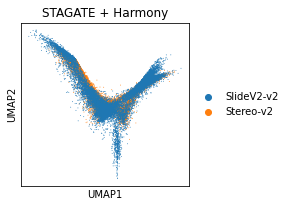

In [21]:
res = pd.DataFrame(ho.Z_corr)
res.columns = adata.obs_names
adata_Harmony = sc.AnnData(res.T)
adata_Harmony.obsm['spatial'] = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names).loc[adata_Harmony.obs_names,].values
adata_Harmony.obs['Tech'] = adata.obs.loc[adata_Harmony.obs_names, 'Tech']
sc.pp.neighbors(adata_Harmony)
sc.tl.umap(adata_Harmony)
sc.tl.louvain(adata_Harmony, resolution=0.8)
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_Harmony, color='Tech', title='STAGATE + Harmony')

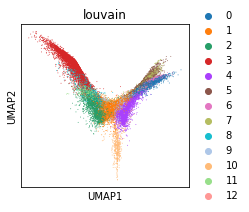

In [22]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_Harmony, color='louvain')

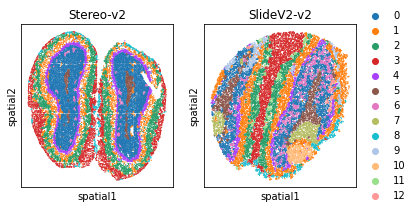

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
it=0
for temp_tech in ['Stereo-v2', 'SlideV2-v2']:
    temp_adata = adata_Harmony[adata_Harmony.obs['Tech']==temp_tech, ]
    if it == 1:
        sc.pl.embedding(temp_adata, basis="spatial", color="louvain",s=6, ax=axs[it],
                        show=False, title=temp_tech)
    else:
        sc.pl.embedding(temp_adata, basis="spatial", color="louvain",s=6, ax=axs[it], legend_loc=None,
                        show=False, title=temp_tech)
    it+=1

In [ ]:
mat=pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
mat=mat.loc[:,adata.var['highly_variable']]
meta=pd.DataFrame(np.array(adata.obs['Tech']),columns=['batch'],index=adata.obs_names)
coord=pd.DataFrame(adata.obsm['spatial'],columns=['x','y'],index=adata.obs_names)
ub=['Stereo-v2', 'SlideV2-v2']
idx1=np.where(meta.loc[:,"batch"]==ub[0])[0]
idx2=np.where(meta.loc[:,"batch"]==ub[1])[0]
mat.iloc[idx1,:].to_csv(dirs+"gtt_input/Stereo-seq-higher-resolution/"+ub[0]+"_mat.csv")
mat.iloc[idx2,:].to_csv(dirs+"gtt_input/Stereo-seq-higher-resolution/"+ub[1]+"_mat.csv")
meta.iloc[idx1,:].to_csv(dirs+"gtt_input/Stereo-seq-higher-resolution/"+ub[0]+"_meta.csv")
meta.iloc[idx2,:].to_csv(dirs+"gtt_input/Stereo-seq-higher-resolution/"+ub[1]+"_meta.csv")
coord.iloc[idx1,:].to_csv(dirs+"gtt_input/Stereo-seq-higher-resolution/"+ub[0]+"_coord.csv")
coord.iloc[idx2,:].to_csv(dirs+"gtt_input/Stereo-seq-higher-resolution/"+ub[1]+"_coord.csv")


Bin35和筛选过的slideseq数据

------Calculating spatial graph...
The graph contains 152608 edges, 19354 cells.
7.8851 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 186962 edges, 18537 cells.
10.0859 neighbors per cell on average.


Size of Input:  (37891, 3000)


100%|██████████| 500/500 [27:50<00:00,  3.34s/it]
... storing 'Tech' as categorical


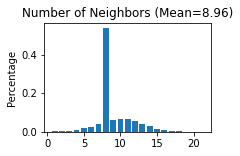

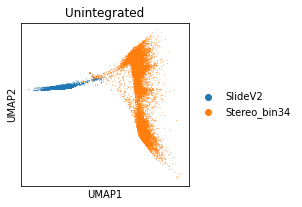

In [162]:
# dirs="/data02/tguo/space_batch_effect/mouse_OB/"
# samples=['Stereo_bin34','SlideV2']
# flags="_"+samples[0]
# for i in np.arange(1,len(samples)):
#     flags=flags+"_"+samples[i]

# adata_list={}
# adata = pd.read_csv(dirs+"gtt_input/"+str(samples[0])+"_mat_allgene.csv",header=0,index_col=0,sep=',')
# adata = anndata.AnnData(adata)
# adata.var_names_make_unique()
# coord=pd.read_csv(dirs+"gtt_input/Stereo-bin34-filter/"+str(samples[0])+"_coord.csv",header=0,index_col=0,sep=',')
# adata.obsm['spatial']=coord.loc[adata.obs_names,:].values
# adata_list[samples[0]] = adata.copy()

# adata = np.transpose(pd.read_csv(dirs+"gtt_input/"+str(samples[1])+"_mat_allgene.csv",header=0,index_col=0,sep=','))
# adata = anndata.AnnData(adata)
# adata.var_names_make_unique()
# adata.obs_names = ['SlideV2-'+x for x in adata.obs_names]
# coord=pd.read_csv(dirs+"gtt_input/Stereo-bin34-filter/"+str(samples[1])+"_coord.csv",header=0,index_col=0,sep=',')
# adata.obsm['spatial']=coord.loc[adata.obs_names,:].values
# adata_list[samples[1]] = adata.copy()

STAGATE.Cal_Spatial_Net(adata_list[samples[0]], rad_cutoff=1.5)
STAGATE.Cal_Spatial_Net(adata_list[samples[1]], rad_cutoff=50)
adata = sc.concat([adata_list[x] for x in samples], keys=None)
adata.uns['Spatial_Net'] = pd.concat([adata_list[x].uns['Spatial_Net']  for x in samples])
STAGATE.Stats_Spatial_Net(adata)

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.obs['Tech'] = [samples[0]]*adata_list[samples[0]].shape[0]+[samples[1]]*adata_list[samples[1]].shape[0]
adata = STAGATE.train_STAGATE(adata, alpha=0)
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='Tech', title='Unintegrated')


In [229]:
data_mat=adata.obsm['STAGATE'].copy()
idx=np.where(data_mat.any(axis=1))[0]
adata1=adata[idx,:]
import harmonypy as hm
data_mat = adata1.obsm['STAGATE'].copy()
meta_data = adata1.obs.copy()
ho = hm.run_harmony(data_mat, meta_data, ['Tech'])
res = pd.DataFrame(ho.Z_corr).T
res.index = adata1.obs_names
res.columns=['harmony-STAGATE_'+str(i) for i in np.arange(res.shape[1])]
flags="_"+samples[0]
for i in np.arange(1,len(samples)):
    flags=flags+"_"+samples[i]
res.to_csv(dirs+"methods/harmony_STAGATE_mat"+flags+".txt")

2023-05-31 12:22:15,885 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-05-31 12:22:55,634 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-05-31 12:22:56,291 - harmonypy - INFO - Iteration 1 of 10
2023-05-31 12:23:19,990 - harmonypy - INFO - Iteration 2 of 10
2023-05-31 12:23:43,950 - harmonypy - INFO - Iteration 3 of 10
2023-05-31 12:24:05,506 - harmonypy - INFO - Converged after 3 iterations


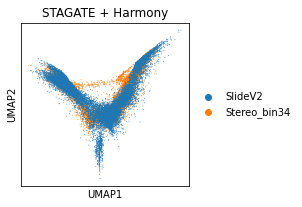

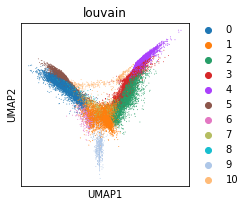

Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.


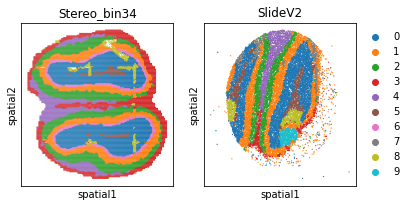

In [232]:
# res = pd.DataFrame(ho.Z_corr)
# res.columns = adata1.obs_names
# adata_Harmony = sc.AnnData(res.T)
# adata_Harmony.obsm['spatial'] = pd.DataFrame(adata1.obsm['spatial'], index=adata1.obs_names).loc[adata_Harmony.obs_names,].values
# adata_Harmony.obs['Tech'] = adata1.obs.loc[adata_Harmony.obs_names, 'Tech']
# sc.pp.neighbors(adata_Harmony)
# sc.tl.umap(adata_Harmony)
sc.tl.louvain(adata_Harmony, resolution=0.5)
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_Harmony, color='Tech', title='STAGATE + Harmony')
pd.DataFrame(adata_Harmony.obs['louvain']).to_csv(dirs+"metrics/harmony_STAGATE"+flags+"_louvain_clust_modify.csv")
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_Harmony, color='louvain')

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
it=0
for temp_tech in ['Stereo_bin34', 'SlideV2']:
    temp_adata = adata_Harmony[adata_Harmony.obs['Tech']==temp_tech, ]
    if it == 1:
        sc.pl.embedding(temp_adata, basis="spatial", color="louvain",s=6, ax=axs[it],
                        show=False, title=temp_tech)
    else:
        sc.pl.embedding(temp_adata, basis="spatial", color="louvain",s=6, ax=axs[it], legend_loc=None,
                        show=False, title=temp_tech)
    it+=1